# Behavioral Exploration:
# Topic Modeling and SNR
 
Exploring the research question: what effect does modifying the input corpus have on the ability to do topic modeling?

TASKS:

- Build the system.
- Test the system under various constraints & make observations about its behaviour.

## Sections

The notebook first establishes a fixed topic model (generic LDA). Then, it defines some properties of corpora that may be modified during experiments. It loads a few corpora and examines their properties. The generic topic model is used to extract topics from these corpora. Performance metrics for the topic model that may be affected by changes in the corpora are defined and calculated on the corpora.

- [Section 1: A Fixed Approach](#1-A-Fixed-Approach)
- [Section 2: Corporus Characteristics](#2-Corpus-Characteristics)
- [Section 3: Choosing Corpora](#3-Choosing-Corpora)
  - [Section 3.1: Wine Reviews](#3.1-Wine-Reviews)
  - [Section 3.2: Brown](#3.2-Brown)
  - [Section 3.3: ABC](#3.3-ABC)
  - [Section 3.4: Genesis](#3.3-Genesis)
  - [Section 3.5: Inaugural](#3.3-Inaugural)
  - [Section 3.6: State of the Union](#3.3-State-of-the-Union)
- [Section 4: Performance Metrics](#4-Performance-Metrics)
- [Section 5: Exploring Results](#5-Exploring-Results)

In [35]:
%load_ext autoreload
%autoreload 2

# 1 A Fixed Approach

This section constructs a baseline model for topic-modeling that is up-to-date on the latest settings for optimal performance. The most widely used and successful topic-modeling approach is [Latent Dirichlet Allocation]() [Blei].

It performs best under the following settings:
- Asymmetric Alpha
- Symmetric Beta

The appropriate number of topics is still somewhat up in the air. Beli et al. say K should be less than the number of documents. TBD is an upper bound on K.

An interesting experiment would be to see on which K the Brown corpus converges since this is theorized to be a relatively broad sample of the English language. It begs the research question, How many topics are there in the Human language?

In [1]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

K = 100
ALPHA = 1/K
BETA = 1/K

# TODO: MAKE ALPHA ASYMMETRIC
lda = LatentDirichletAllocation(n_components=K,
                                doc_topic_prior=ALPHA,
                                topic_word_prior=BETA,
                                learning_method='online')

# This is reusable, we'll fit it separately to each corpus
# Converts a list of documents into their word-counts,
# after removing stopwords.
tf_vectorizer = CountVectorizer(stop_words='english')

def get_model(data_samples):
    # Build the model
    model_components = {}
    tf = tf_vectorizer.fit_transform(data_samples)
    lda.fit(tf) 
    # Piece together model components
    model_components['features'] = tf_vectorizer.get_feature_names()
    model_components['topic_word'] = lda.components_
    model_components['doc_word'] = tf
    model_components['doc_topic'] = lda.transform(tf)
    return model_components

def get_top_words(model, feature_names, n_top_words=10):
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        sorted_top = topic.argsort()[:-n_top_words-1:-1]
        top_words[topic_idx] = [feature_names[i] for i in sorted_top]
    return top_words

def print_top_words(model, feature_names, n_top_words=10):
    top_words = get_top_words(lda,feature_names,n_top_words)
    for topic in top_words:
        words = ' '.join(top_words[topic])
        print("Topic_{}: {}".format(topic,words))

# 2 Corpus Characteristics

I decided it would be easier to define an new corpus reader object that extends NLTK's existing PlaintextCorpusReader. This can be found in `corpus.py`. It extends PlaintextCorpusReader by adding characteristics to the corpus so that the user can ask basic questions like how many documents are there? What is their average word count? A lot of the characteristics are straightforward. For those that aren't, an explanation is provided.

So far the characteristics I have defined are:
- Number of documents
- Average document length (in words)
- Vocab size
- Readability ([smog index](https://en.wikipedia.org/wiki/SMOG))
- Distance from uniform distribution
- [Lexical diversity](http://textinspector.com/help/?page_id=136)
- Stopword presence (what percentage of the corpus is stopwords?)

Still TODO are:
- Stability
- Inherent Topics

# 3 Choosing Corpora

In this section I'm going to load some various real-world corpora and test out the different metrics. This is really the __behavioural exploration__ section. After fixing any bugs in the metrics, I'll start making some initial observations of the system to see if I can find hints of phenomena or correlations.

In [2]:
# The corpus reader I created to make things easier
from corpus import PropertiesCorpusReader

## 3.1 Wine Reviews

This first corpus is a collection of wine reviews. It's an example of a small corpus with short-text documents. Unfortunately they've all been joined into one big file so we need to do a little manual labour to separate the individual short reviews. This means creating a new nltk corpus reader object from the one big wine review document.

In [3]:
import os

from nltk.corpus import webtext
from nltk.corpus.reader.plaintext import PlaintextCorpusReader

wine_doc = webtext.raw('wine.txt')

# Individual reviews are split by newline characters
wine_reviews = list(filter(None,wine_doc.split('\n')))

if not os.path.exists('wine_files'):
    os.makedirs('wine_files')
    
fileids = []
for i in range(len(wine_reviews)):
    fn = '{:04}.txt'.format(i)
    fileids.append(fn)
    with open(os.path.join('wine_files',fn),'w') as f:
        f.write(wine_reviews[i])
    f.close()
wine_cr = PlaintextCorpusReader('wine_files',
                                fileids,
                                word_tokenizer=webtext._word_tokenizer,
                                sent_tokenizer=webtext._sent_tokenizer,
                                para_block_reader=webtext._para_block_reader,
                                encoding=webtext._encoding)

Now let's convert the new corpus reader into a PropertiesCorpusReader object and explore its characteristics. 

In [4]:
wine_pcr = PropertiesCorpusReader(wine_cr)

Calculating properties...
	Readability calculated.
	Distance from uniform calculated.
	Lexical diversity calculated.
	Stopword presence calculated.


In [5]:
wine_pcr.print_properties()

Number of documents: 1230
Average document length: 25.4943
Vocab size: 3417
Readability: 276.1483
Distance from uniform: 0.8687
Lexical diversity: 0.1090
Stopword presence: 0.2613


After gathering characteristics of the corpus, the next step is to see how well the generic LDA model can decipher topics from it.

In [6]:
data_samples = wine_pcr.raw_docs()
wine_components = get_model(data_samples)

The following are the matrices we need to calculate model performance. They are:

|Name|Shape|Description|
|:-|:-|:-|:-|
|topic_word|(n_topics,n_words)|Distribution of vocabulary words in each topic. Each cell answers the question: What is the likelihood of seeing this word in this topic?|
|document_word|(n_documents,n_words)|Count of vocabulary words in each document. Each cell answers the question: How many times did this word appear in this document? __This is a SPARSE MATRIX__|
|document_topic|(n_documents,n_topics)|The proportion of each document that is made up by the different topics. It answers the question: What percentage of this document talks about this topic?|
|features|(n_words,)|The literal words associated with each index in the topic_word and doc_word matrices.|

In [7]:
wine_components['topic_word'].shape

(100, 2589)

In [8]:
wine_components['doc_word'].shape

(1230, 2589)

In [9]:
wine_components['doc_topic'].shape

(1230, 100)

In [10]:
len(wine_components['features'])

2589

## 3.2 Brown

The Brown corpora is probably one of the most famous ones out there. It's the polar opposite of the wine reviews because instead of a few short documents, it has a lot of long documents. Which means it takes a really long time to build a PropertiesCorpusRedaer object of it, so verbosity is a nice sanity check while it's running.

In [11]:
from nltk.corpus import brown
brown_pcr = PropertiesCorpusReader(brown)

Calculating properties...
	Readability calculated.
	Distance from uniform calculated.
	Lexical diversity calculated.
	Stopword presence calculated.


In [12]:
brown_pcr.print_properties()

Number of documents: 500
Average document length: 2322.3840
Vocab size: 66939
Readability: 11.3273
Distance from uniform: 0.9709
Lexical diversity: 0.0576
Stopword presence: 0.0000


In [13]:
data_samples = brown_pcr.raw_docs()
brown_components = get_model(data_samples)

## 3.3 ABC

A corpus of news files.

In [14]:
from nltk.corpus import abc
abc_pcr = PropertiesCorpusReader(abc)

Calculating properties...
	Readability calculated.
	Distance from uniform calculated.
	Lexical diversity calculated.
	Stopword presence calculated.


In [15]:
abc_pcr.print_properties()

Number of documents: 2
Average document length: 383405.5000
Vocab size: 31885
Readability: 12.1194
Distance from uniform: 0.9425
Lexical diversity: 0.0416
Stopword presence: 0.3499


In [16]:
data_samples = abc_pcr.raw_docs()
abc_components = get_model(data_samples)

## 3.4 Genesis

NLTK King James Bible?

In [17]:
from nltk.corpus import genesis
genesis_pcr = PropertiesCorpusReader(genesis)

Calculating properties...
	Readability calculated.
	Distance from uniform calculated.
	Lexical diversity calculated.
	Stopword presence calculated.


In [18]:
genesis_pcr.print_properties()

Number of documents: 8
Average document length: 39408.5000
Vocab size: 25841
Readability: 8.4613
Distance from uniform: 0.9343
Lexical diversity: 0.0820
Stopword presence: 0.3755


In [19]:
data_samples = genesis_pcr.raw_docs()
genesis_components = get_model(data_samples)

## 3.5 Inaugural Address

A collection of 55 inaugural addresses from presidents.

In [20]:
from nltk.corpus import inaugural
inaugural_pcr = PropertiesCorpusReader(inaugural)

Calculating properties...
	Readability calculated.
	Distance from uniform calculated.
	Lexical diversity calculated.
	Stopword presence calculated.


In [21]:
inaugural_pcr.print_properties()

Number of documents: 56
Average document length: 2602.4107
Vocab size: 9754
Readability: 23.4806
Distance from uniform: 0.9143
Lexical diversity: 0.0669
Stopword presence: 0.4499


In [22]:
data_samples = inaugural_pcr.raw_docs()
inaugural_components = get_model(data_samples)

## 3.6 State of the Union

Collection of State of the Union addresses.

In [23]:
from nltk.corpus import state_union
state_union_pcr = PropertiesCorpusReader(state_union)

Calculating properties...
	Readability calculated.
	Distance from uniform calculated.
	Lexical diversity calculated.
	Stopword presence calculated.


In [24]:
state_union_pcr.print_properties()

Number of documents: 65
Average document length: 6151.1077
Vocab size: 14591
Readability: 17.6455
Distance from uniform: 0.9230
Lexical diversity: 0.0365
Stopword presence: 0.3888


In [25]:
data_samples = state_union_pcr.raw_docs()
state_union_components = get_model(data_samples)

# 4 Performance Metrics

Metrics should adhere to the following axioms:
- Similar models or topics should have similar scores.
- Different models or topics should have differing scores.
- Scores should change when the model changes.

We should also consider metrics that have been tested in previous work to rule them in/out as informative of performance. 

In addition, metrics should be able to be calculated on any matrices regardless of how they were created (using LDA or not).

So far, the metrics defined are:
- Exclusivity
- [Jensen-Shannon Divergence](https://stackoverflow.com/questions/15880133/jensen-shannon-divergence
- Effective size
- Average word length
- Rank1

Still TODO are:
- Classification
- Point-wise mutual information
- Coherence
- SNR

When possible, metrics are calculated separately for each individual topic.

PMI source:

[Newman et al. 2011](http://papers.nips.cc/paper/4291-improving-topic-coherence-with-regularized-topic-models.pdf)

In [ ]:
models_metrics = []
for model in all_model_components:
    models_metrics = 

In [114]:
import metrics

all_components = {'wine':wine_components,
                  'brown':brown_components,
                  'abc':abc_components,
                  'genesis':genesis_components,
                  'inaugural':inaugural_components,
                  'state_union':state_union_components}

pcrs = {'wine':wine_pcr,
        'brown':brown_pcr,
        'abc':abc_pcr,
        'genesis':genesis_pcr,
        'inaugural':inaugural_pcr,
        'state_union':state_union_pcr}

def get_metric(name,met):
    results = []
    metric_func = getattr(metrics,met)
    for i in range(K):
        results.append(metric_func(all_components[name],i))
    return results

def get_property(name,prop):
    pcr = pcrs[name]
    return getattr(pcr,prop)

# 5 Exploring Results

Since LDA is a BOW model, the words themselves are not important for most measures (except complexity).

For complexity, we know what affects the complexity score. If we modify that, how does LDA performance change?

TODO: Find/generate corpora that satisfy the characteristics defined above and train the baseline model on them.

In [63]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

Build the plot sources. Tabs will be used to switch between corpus properties.

In [158]:
from bokeh.models import ColumnDataSource

# Each source is a different property with all the metrics.
properties = ['num_docs','avg_doc_len','vocab_size',
              'readability','lexical_diversity',
              'stopword_presence']
topic_metrics = ['average_word_length','exclusivity',
                 'rank1','distance_from_uniform']
names = ['wine','brown','abc','genesis','inaugural','state_union']

sources = {}
for p in properties:
    source_dict = {}
    for n in names:
        val = get_property(n,p)
        x = [val]*K
        source_dict['{}_x'.format(n)] = x
        for tm in topic_metrics:
            y = get_metric(n,tm)
            source_dict['{}_{}_y'.format(n,tm)] = y
    sources[p] = ColumnDataSource(source_dict)

Build the plot.

In [149]:
from bokeh.models.widgets import Panel, Tabs
from bokeh.models import HoverTool

def plot_metric(metric_name):
    colors = {'wine':'red',
              'brown':'orange',
              'abc':'yellow',
              'genesis':'green',
              'inaugural':'blue',
              'state_union':'purple'}

    hover = HoverTool(tooltips=[('x','$x'),('y','$y')])
    
    property_tabs= []
    figs = {}
    for p in properties:
        fig = figure(x_axis_label=p,
                     y_axis_label=metric_name,
                     tools=[hover,PanTools])

        for n in names:
            fig.circle(x='{}_x'.format(n),
                       y='{}_{}_y'.format(n,metric_name),
                       source=sources[p],
                       size=10, color=colors[n], alpha=0.5,legend=n)
        fig.legend
        figs[p] = fig
        property_tabs.append(Panel(child=fig, title=p))

    tabs = Tabs(tabs=property_tabs)

    show(tabs,notebook_handle=True)

In [150]:
plot_metric('exclusivity')

In [157]:
figs['avg_doc_len'].tools

[PanTool(id='fdf19bd4-c20b-4ab4-b243-077de9656ff6', ...),
 WheelZoomTool(id='6c480bdb-362b-4030-90e6-7c0eeb6041a1', ...),
 BoxZoomTool(id='9b0ac7b2-9de0-4317-a239-ac366a3528b4', ...),
 SaveTool(id='fd54e029-2cb9-430c-b5a5-e9c17c956197', ...),
 ResetTool(id='581d1201-4dfe-44f0-a331-cf5a9f0e8bec', ...),
 HelpTool(id='a3d1be7c-c7b1-4b9a-a467-0651bb3036e2', ...)]

In [172]:
import numpy as np
np.max(sources['num_docs'].data['state_union_rank1_y']),state_union_pcr.num_docs

(65, 65)

In [166]:
plot_metric('rank1')

### Obervations:

The __number of documents__ seems to lead to an increase in rank1 of topics 

Increase in __lexical diversity__ of the corpus seems to cause exponential increase in the rank1 metric for topics.

Future results would probably benefit from combining average document length with the number of documents. Maybe (avg_doc_len) x (num_docs).

In [152]:
plot_metric('distance_from_uniform')

Topic distance from uniform distribution seems to be negatively impacted by both __average document length__ and __vocabulary size__. Interestingly, lexical diversity does not seem to have an impact.

In [153]:
plot_metric('average_word_length')

<IPython.core.display.Javascript object>


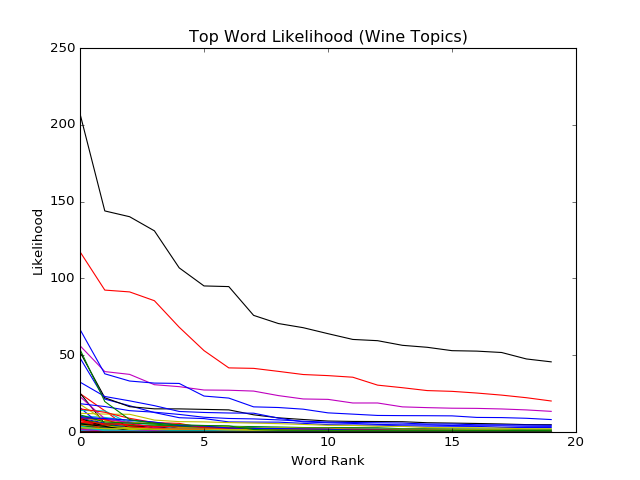

In [323]:
plt.figure()
plt.title("Top Word Likelihood (Wine Topics)")

for k in range(100):
    top_words_idx = wine_topic_word[k].argsort()[:-20-1:-1]
    x = np.arange(20)
    y = [wine_topic_word[k][i] for i in top_words_idx]
    plt.plot(x,y)
plt.ylabel("Likelihood")
plt.xlabel("Word Rank")
plt.savefig('figures/wine_word_likelihood.png',dpi=300)
plt.show()